# Echo State Networks

An implementation of ESNs heavily inspired by the toolbox by H. Jaeger [[1]](http://minds.jacobs-university.de/uploads/SW/ESNToolbox.zip) and the minimal version created by M. Lukoševičius [[2]](http://minds.jacobs-university.de/uploads/mantas/code/minimalESN.py.txt).

## Links (to assumptions)
[[3]](http://www.scholarpedia.org/article/Echo_state_network)
[[4]](http://minds.jacobs-university.de/uploads/papers/PracticalESN.pdf)
[[5]](http://minds.jacobs-university.de/uploads/papers/2261_LukoseviciusJaeger09.pdf)
[[6]](http://www.lsv.fr/~monmege/teach/learning/KI_reservoir_computing.pdf)
[[7]](http://minds.jacobs-university.de/uploads/papers/tfbesn_iubtechreport.pdf)
[[8]](http://minds.jacobs-university.de/uploads/papers/ESNTutorialRev.pdf)
[[9]](http://minds.jacobs-university.de/uploads/papers/2399_LiJaeger11.pdf)
[[10]](http://hardcarve.com/wikipic/Mayer_EchoStateNetworkSelfPrediction.pdf)

[[Polydoros et. al.]](https://www.cs.unm.edu/~afaust/MLPC15_proceedings/MLPC15_paper_Polydoros.pdf)

### TODO
* Clean up, organize
* Comments!
* Error calculation for performance evaluation
* Test function
* Implement online update algorithm

## Import

In [21]:
from numpy import *
from matplotlib import pyplot as plt
from scipy.sparse import rand as sprand
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs as speigs

## Helper functions

In [18]:
#def computeRMSE():

def normalize_input(inputSequence):
    iMu = mean(inputSequence, axis=0)
    iMax = amax(abs(inputSequence), axis=0)
    normInputSequence = (inputSequence-iMu)/iMax
    return normInputSequence

In [22]:
class ESN():
    def __init__(self,nInputUnits,nReservoirUnits,nOutputUnits,spectralRadius):
        print('Creating Echo State Network...')
        ### STRUCTURE
        self.nInputUnits = nInputUnits
        self.nReservoirUnits = nReservoirUnits
        self.nOutputUnits = nOutputUnits
        self.nTotalUnits = nInputUnits + nReservoirUnits + nOutputUnits
        
        self.spectralRadius = spectralRadius

        ### INITIALIZE WEIGHTS
        ## JAEGER (Sparse reservoir weights) (Polydoros et. al. Algorithm 1)
        success = 0                                             
        while success == 0: # following block might fail
            try:
                self.Wres = sprand(nReservoirUnits, nReservoirUnits, density=10/nReservoirUnits)
                self.Wres = self.Wres.toarray()
                self.Wres[self.Wres!=0] -= 0.5 # modify only nonzero elements
                self.Wres = csr_matrix(self.Wres) # back to sparse
                maxVal = max(abs(speigs(A=self.Wres, k=1, which='LM')[0]))
                self.Wres /= maxVal
                success = 1
            except:
                success = 0   
        self.Wres *= self.spectralRadius
        
        ## MANTAS (Standard array)
        #self.Wres = random.rand(nReservoirUnits, nReservoirUnits)-0.5
        #rho = max(abs(scipy.linalg.eig(self.Wres)[0]))
        #self.Wres *= 1.25 / rho

        self.Win = 2.0 * random.rand(nReservoirUnits, nInputUnits)- 1.0
        self.Wout = zeros((nOutputUnits, nReservoirUnits + nInputUnits))
        self.Wfb = (2.0 * random.rand(nReservoirUnits, nOutputUnits)- 1.0)

        ### INIT DEFAULT PARAMETERS
        self.inputScaling = ones((nInputUnits, 1)) # MAKE SURE INPUT IS NORMALIZED!!!
        self.inputShift = zeros((nInputUnits, 1))
        self.teacherScaling = ones((nOutputUnits, 1)) # DOES TEACHER SCALING MAKE ANY DIFFERENCE???
        self.teacherShift = zeros((nOutputUnits, 1))
        self.teacherForcing = True # Desired output y_teacher instead of predicted y -> Ridge regression!!!  
        self.feedbackScaling = zeros((nOutputUnits, 1))
        
        self.noiseLevel = 0.0
        self.leakingRate = 1
        self.forgetPoints = 100
        self.reg = 1e-5 # If ridge regression!!! (something else than 1)
        
        self.RLS_lambda = 0.9999995
        self.RLS_delta = 0.000001

        self.trained = 0
        self.pseudo = True
        
        print('Successful!')
    
    def train_single(self,inputSequence,outputSequence):
        ## STATE COLLECTION
        nDataPoints = outputSequence.shape[0]
        self.stateCollect = zeros((nDataPoints - self.forgetPoints, self.nInputUnits + self.nReservoirUnits))
        self.totalState = zeros((self.nInputUnits + self.nReservoirUnits + self.nOutputUnits, 1))
        self.reservoirState = zeros((self.nReservoirUnits, 1))
        
        print('Training...')
        collectIndex = 0;
        for i in range(nDataPoints):
            IN = self.inputScaling * array([inputSequence[i,:]]).T + self.inputShift
            self.totalState[self.nReservoirUnits:self.nReservoirUnits+self.nInputUnits, :] = IN;

            # PLAIN ESN (OR LEAKY) # Wres.array if sparse
            self.reservoirState = tanh(hstack((self.Wres.toarray(), self.Win, self.Wfb@ \
                                               diag(self.feedbackScaling[:,0])))@self.totalState)
        
            # Adding noise, more computational but seems to stabilize solutions in models with output feedback
            self.reservoirState += self.noiseLevel *(random.rand(self.nReservoirUnits,1) - 0.5)
            
            if self.teacherForcing:
                self.netOut = self.teacherScaling * array([outputSequence[i,:]]).T + self.teacherShift
            else:
                self.netOut = self.Wout @ vstack((self.reservoirState, IN)) # activation function identity
                
            self.totalState = vstack((self.reservoirState, IN, self.netOut))
            
            if i > self.forgetPoints:
                collectIndex = collectIndex + 1;
                self.stateCollect[collectIndex,:] = hstack((self.reservoirState.T, IN.T))
        
        ## TEACHER COLLECTION
        nOutputPoints  = outputSequence.shape[0]
        self.teacherCollect = zeros(((nOutputPoints - self.forgetPoints), self.nOutputUnits))
        
        outputSequence = outputSequence[self.forgetPoints:,:]
        nOutputPoints = outputSequence.shape[0] # update the size of outputSequence

        self.teacherCollect = array((diag(self.teacherScaling[:,0]) @ outputSequence.T).T + \
                                    matlib.repmat(self.teacherShift.T,nOutputPoints, 1))
        
        if self.pseudo: # (WIENER-HOPF, faster but less stable than pin, H.Jaeger)
            self.Wout = (linalg.pinv(self.stateCollect)@self.teacherCollect).T
                               
        else: # Ridge regression 'Tikhonov' (the larger alpha the smoother output,zero then same)
            covMat = self.stateCollect.T @ self.stateCollect / self.stateCollect.shape[0]
            pVec = self.stateCollect.T @ self.teacherCollect / self.stateCollect.shape[0]
            self.Wout = (linalg.inv(covMat+(self.reg**2)*eye(covMat.shape[0])) @ pVec).T
        
        self.trained = 1
        print('Training finished!')
        
        
    def train_online(self,trainInput,trainOutput): # FROM H.JAEGER TOOLBOX (RLS ALGORITHM)
        nSampleInput = trainInput.shape[0]
        self.stateCollect = zeros((nSampleInput, self.nReservoirUnits + self.nInputUnits))
        SInverse = 1 / self.RLS_delta * eye(self.nReservoirUnits + self.nInputUnits)
        self.totalState = zeros((self.nTotalUnits,1))
        reservoirState = zeros((self.nReservoirUnits,1)) 
        error = zeros((nSampleInput , 1)) 
        weights = zeros((nSampleInput , 1)) 
        
        print('Training...')
        for j in range(nSampleInput):
            IN = self.inputScaling * array([trainInput[j,:]]).T + self.inputShift 
            
            #write input into totalstate
            self.totalState[self.nReservoirUnits:self.nReservoirUnits+self.nInputUnits,:] = IN
            
            # update totalstate except at input positions
            self.reservoirState = tanh(hstack((self.Wres.todense(), self.Win, self.Wfb@ \
                                               diag(self.feedbackScaling[:,0])))@self.totalState)
        
            # Adding noise, more computational but seems to stabilize solutions in models with output feedback
            self.reservoirState += self.noiseLevel *(random.rand(self.nReservoirUnits,1) - 0.5)
            
            self.netOut = self.Wout @ vstack((self.reservoirState, IN)) # activation function identity
            self.totalState = vstack((self.reservoirState, IN, self.netOut))  
            
            state = vstack((self.reservoirState, IN)) 
            
            self.stateCollect[j, :] = state.T
            phi = state.T * SInverse
            k = phi.T/(self.RLS_lambda + phi * state)
            e = self.teacherScaling * trainOutput[j,0] + self.teacherShift - self.netOut[0,:]
            
            # update the weights 
            self.Wout[0,:] = self.Wout[0,:] + (k*e).T 
                                               
            SInverse = (SInverse-k*phi) / self.RLS_lambda
            
        self.trained = 1
        print('Training finished!')
        
                               
    def test(self, inputSequence):
        nDataPoints = inputSequence.shape[0]
        self.stateCollect = zeros((nDataPoints - self.forgetPoints, self.nInputUnits + self.nReservoirUnits))
        self.totalState = zeros((self.nInputUnits + self.nReservoirUnits + self.nOutputUnits, 1))
        self.reservoirState = zeros((self.nReservoirUnits, 1))
        
        collectIndex = 0;
        for i in range(nDataPoints):
            IN = self.inputScaling * array([inputSequence[i,:]]).T + self.inputShift
            self.totalState[self.nReservoirUnits:self.nReservoirUnits+self.nInputUnits, :] = IN;

            # Plain update
            self.reservoirState = tanh(hstack((self.Wres.toarray(), self.Win, self.Wfb@ \
                                               diag(self.feedbackScaling[:,0])))@self.totalState)
        
            # Adding noise, more computational but seems to stabilize solutions in models with output feedback
            self.reservoirState += self.noiseLevel *(random.rand(self.nReservoirUnits,1) - 0.5)
            
            self.netOut = self.Wout @ vstack((self.reservoirState, IN)) # activation function identity
                
            self.totalState = vstack((self.reservoirState, IN, self.netOut))
            
            if i > self.forgetPoints:
                collectIndex = collectIndex + 1;
                self.stateCollect[collectIndex,:] = hstack((self.reservoirState.T, IN.T))
                
        yPred = self.stateCollect @ self.Wout.T
        
        # plot prediction vs true sequence
        plt.figure(2)
        plt.plot(yPred[0:200,0], 'c--',label='Predicted')
        plt.xlabel('Sample')
        plt.ylabel('Torque [Nm]')
        plt.legend()

        

## Process data

In [4]:
nInputs = 21
nOutputs = 7
split = 0.5

data = genfromtxt('Sarcos.csv', delimiter=',')
ind = round(split*data.shape[0])

uTrain = data[0:ind,0:nInputs]
yTrain = data[0:ind,nInputs:]
uTest = data[ind:,0:nInputs]
yTest = data[ind:,nInputs:]

# Normalize input
uTrain = normalize_input(uTrain)
uTest = normalize_input(uTest)

## Demo (All inputs, few outputs, few reservoir nodes)

Creating Echo State Network...
Successful!
Training...
Training finished!


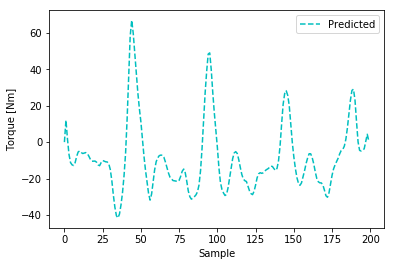

In [23]:
# Extract first torque vector
nOutputs = 1
yTrain = yTrain[:,0:1]
yTest = yTest[:,0:1]

# Parameters
nReservoir = 20
spectralRadius = 0.4

# Train and test
esn = ESN(nInputs, nReservoir, nOutputs,spectralRadius)

#esn.train_single(uTrain,yTrain)
esn.train_online(uTrain,yTrain)

esn.test(uTrain)


## Scrap yard

In [ ]:
yPred = self.stateCollect @ self.Wout.T


# scale and shift the outputSequence back to its original size
nOutputPoints = yPred.shape[0] 
yPred -= matlib.repmat(self.teacherShift.T,nOutputPoints, 1)
yPred /= diag(self.teacherScaling)


# plot prediction vs true sequence
plt.figure(2)
plt.plot(trainOutput[0:200,0], 'g',label='True')
plt.plot(yPred[0:200,0], 'b',label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Torque [Nm]')
plt.legend()


## Plotting the traces of a few states is good practice - H.Jaeger)
plt.figure(1)
plt.subplot(221)
plt.plot(self.stateCollect[0:200,0], 'b')
plt.subplot(222)
plt.plot(self.stateCollect[0:200,1], 'b')
plt.subplot(223)
plt.plot(self.stateCollect[0:200,3], 'b')
plt.subplot(224)
plt.plot(self.stateCollect[0:200,4], 'b')
plt.suptitle('Trace of a few states')


# ONLINE 
# collect the error that will be plotted, error[j,0] = e*e
# collect the weights for plotting, weights[j,0] = sum(abs(self.Wout[0,:]))  